# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import to_date
from pyspark.ml.feature import Normalizer,VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator



import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# create a Spark session
configure = SparkConf().setAppName('Sparkify').setMaster('local')
sc = SparkContext(conf = configure)

In [3]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '63120'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.id', 'local-1608520029662'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '10.12.3.24')]

In [5]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Load the dataset
path = 'mini_sparkify_event_data.json'
event_data = spark.read.json(path)
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# number of rows in dataset
event_data.count()

286500

### Drop Rows with Missing Values

In [8]:
# Drop rows with NaN in UserID and SessionID
event_data_valid = event_data.dropna(how = "any", subset = ["userId", "sessionId"])

In [9]:
# count number of rows
event_data_valid.count()

286500

**Seems there is no missing value in UserID and SessionID, but we need to take a closer look of the data to make sure.**

In [10]:
event_data_valid.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [11]:
event_data_valid.select("sessionId").dropDuplicates().sort("sessionId").show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



**We can see that there are empty strings in UserID and SessionID is clean. 
Then we need to drop those empty strings in UserID**

In [12]:
event_data_valid = event_data_valid.filter(event_data_valid["userId"] != "")

In [13]:
event_data_valid.count()

278154

**We also want to take a look at all the other fieds we have. To help us decide whether those fields can be used in our model later.**

In [14]:
event_data_valid.select([count(when(isnan(c), c)).alias(c) for c in event_data_valid.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



**Great! Seems we have a very clean dataset**

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

#### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Time span

**When is the start and end date of our dataset**

In [32]:
# Create a function that returns the desired string from a timestamp 
def format_timestamp(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d')

# Create the UDF
get_date = udf(lambda x: format_timestamp(x/1000))

In [33]:
event_data_valid = event_data_valid.withColumn("date", get_date(event_data_valid.ts))

In [34]:
event_data_valid.select(['date']).dropDuplicates().sort("ts").show()

+----------+
|      date|
+----------+
|2018-09-30|
|2018-10-01|
|2018-10-02|
|2018-10-03|
|2018-10-04|
|2018-10-05|
|2018-10-06|
|2018-10-07|
|2018-10-08|
|2018-10-09|
|2018-10-10|
|2018-10-11|
|2018-10-12|
|2018-10-13|
|2018-10-14|
|2018-10-15|
|2018-10-16|
|2018-10-17|
|2018-10-18|
|2018-10-19|
+----------+
only showing top 20 rows



### Number of users

In [15]:
event_data_valid.select("userID").agg(countDistinct('userId')).show()

+-------------+
|count(userId)|
+-------------+
|          225|
+-------------+



### Gender Distribution

In [23]:
songs_by_gender = event_data_valid.filter(event_data_valid.page == "NextSong").groupby(event_data_valid.gender).count().orderBy(event_data_valid.gender)
songs_by_gender.show()

+------+------+
|gender| count|
+------+------+
|     F|126696|
|     M|101412|
+------+------+



In [24]:
user_by_gender = event_data_valid.groupBy('gender').agg(countDistinct('userId'))
user_by_gender.show()

+------+-------------+
|gender|count(userId)|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



**We can see that although in our users, we have less female than male, female contribute to more song plays.**

### Loacation Distribution

In [25]:
songs_by_location = event_data_valid.filter(event_data_valid.page == "NextSong").groupby(event_data_valid.location).count().sort(col('count').desc())
songs_by_location.show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|24861|
|New York-Newark-J...|19268|
|Boston-Cambridge-...|11415|
|Houston-The Woodl...| 7832|
|Charlotte-Concord...| 6433|
|Dallas-Fort Worth...| 6188|
|Louisville/Jeffer...| 5664|
|Philadelphia-Camd...| 4799|
|Chicago-Napervill...| 4088|
|Vineland-Bridgeto...| 4079|
|Phoenix-Mesa-Scot...| 3956|
|    St. Louis, MO-IL| 3923|
|          Wilson, NC| 3816|
|Denver-Aurora-Lak...| 3725|
|           Ionia, MI| 3632|
|San Antonio-New B...| 3602|
|        Danville, VA| 3573|
|Atlanta-Sandy Spr...| 3479|
|New Haven-Milford...| 3364|
|         Jackson, MS| 3236|
+--------------------+-----+
only showing top 20 rows



In [26]:
user_by_location = event_data_valid.groupBy('location').agg(countDistinct('userId')).sort(col('count(userId)').desc())
user_by_location.show()

+--------------------+-------------+
|            location|count(userId)|
+--------------------+-------------+
|Los Angeles-Long ...|           16|
|New York-Newark-J...|           15|
|Dallas-Fort Worth...|            7|
|Phoenix-Mesa-Scot...|            7|
|    St. Louis, MO-IL|            6|
|Chicago-Napervill...|            6|
|Charlotte-Concord...|            6|
|Philadelphia-Camd...|            5|
|Miami-Fort Lauder...|            5|
|Boston-Cambridge-...|            5|
|Atlanta-Sandy Spr...|            4|
|Washington-Arling...|            4|
|Houston-The Woodl...|            4|
|San Diego-Carlsba...|            3|
|Las Vegas-Henders...|            3|
|New Haven-Milford...|            3|
|Providence-Warwic...|            2|
|San Antonio-New B...|            2|
|Indianapolis-Carm...|            2|
|         Jackson, MS|            2|
+--------------------+-------------+
only showing top 20 rows



In [27]:
avg_play = udf(lambda x, y: x / y if y!=0 else 0)

In [105]:
user_location_songs = songs_by_location.join(user_by_location, on=['location'], how='left_outer')
user_location_songs = user_location_songs.withColumn('Average_Play', avg_play('count', 'count(userId)')).sort(col('Average_Play').cast('float').desc())
user_location_songs.select('location').dropDuplicates().agg(countDistinct('Location')).show()

+---------------+
|count(Location)|
+---------------+
|            114|
+---------------+



**Plot a bar chart to see the top 10 locations with highest average songs played**

In [29]:
user_location_songs_df = user_location_songs.toPandas()
user_location_songs_df['Average_Play'] = pd.to_numeric(user_location_songs_df['Average_Play'])

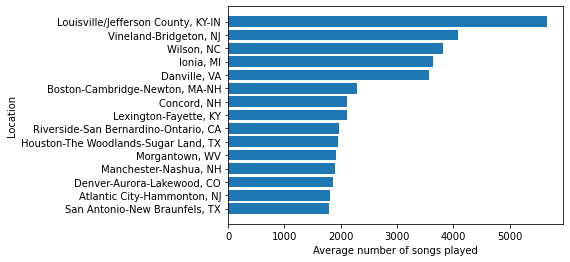

In [106]:
user_location_songs_df_sub = user_location_songs_df.head(15).sort_values('Average_Play')
plt.barh(user_location_songs_df_sub['location'], user_location_songs_df_sub['Average_Play'])
plt.ylabel("Location")
plt.xlabel("Average number of songs played");


In [16]:
## all kinds of pages
event_data_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Calculating Statistics by Hour

In [17]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [18]:
event_data_valid = event_data_valid.withColumn("hour", get_hour(event_data_valid.ts))

In [19]:
songs_in_hour = event_data_valid.filter(event_data_valid.page == "NextSong").groupby(event_data_valid.hour).count().orderBy(event_data_valid.hour.cast("float"))

In [20]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 8142|
|   1| 8154|
|   2| 8043|
|   3| 8184|
|   4| 8360|
|   5| 8560|
|   6| 8695|
|   7| 9214|
|   8| 9512|
|   9|10023|
|  10|10770|
|  11|11365|
|  12|11571|
|  13|11333|
|  14|10973|
|  15|10966|
|  16|10839|
|  17|10262|
|  18| 9947|
|  19| 9360|
+----+-----+
only showing top 20 rows



In [21]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

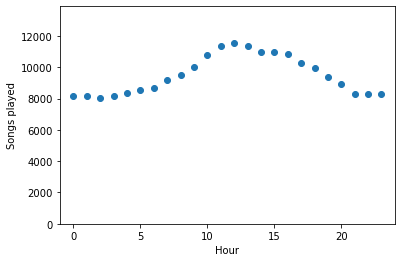

In [22]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

**On Average, more songs are played around noon compare other times**

### Define Chrun


In [35]:
event_data_valid.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|      date|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|  16|2018-10-07|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000| 

In [36]:
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [37]:
event_data_valid = event_data_valid.withColumn("chrun", flag_cancel_event("page"))

In [38]:
event_data_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='20', date='2018-09-30', chrun=0)


Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [39]:
event_data_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|      date|chrun|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|   7|2018-10-01|    0|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|15371207570

In [40]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [41]:
event_data_valid = event_data_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [42]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [43]:
event_data_valid = event_data_valid.withColumn("phase", Fsum("downgraded").over(windowval))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [44]:
df = event_data_valid.groupby(['userID', 'gender']).pivot('page').agg(count('page'))

In [45]:
# add label -- chrun
df = df.withColumn('chrun', when(col('Cancellation Confirmation') > 0, 1).otherwise(0).cast("integer"))

In [46]:
# add feature - downgrade
df = df.withColumn('downgraded', when(col('Downgrade') > 0, 1).otherwise(0).cast("integer"))

In [47]:
# fill na with 0
df = df.na.fill(0)

In [48]:
df.show()

+------+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+----------+
|userID|gender|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|chrun|downgraded|
+------+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+----------+
|    44|     F|    3|         8|             10|     0|                        0|        1|    0|   6|  15|     6|     429|          0|            1|       4|               0|             1|          2|       25|      1|    0|         1|
|    46|     F|    3|        18|             30|

In [49]:
# level, number of page-thumbs up, gender, downgrade or not, number of songs listened
# number of days since log in 

In [50]:
# number of songs listened more or less

In [51]:
# create phase for downgrade, phase 1, phase 0
# create downgrade indicator, 1, 0

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Before modeling, we can check if there is any feature has strong correlation with chrun. And also check the correlations between the features that we are planning to use. 

In [52]:
# correlation between downgrade and cancellation

vector_col = "corr_features"
columns = ['chrun','Add Friend','Add to Playlist','downgraded',\
            'Error', 'NextSong', 'Upgrade', 'Thumbs Down', \
            'Thumbs Up']
assembler = VectorAssembler(inputCols= columns, 
                            outputCol=vector_col)
df_vector = assembler.transform(df)
scaler = Normalizer(inputCol="corr_features", outputCol="ScaledFeatures")

df_vector = scaler.transform(df_vector).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)


In [53]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix[0])

[1.0, -0.18095621553413202, -0.15187455050425933, -0.013410265703587968, -0.18828663391867329, -0.1561097592261295, -0.013729980485466814, -0.07466759597089637, -0.16810479210120885]


<ipython-input-54-2a0efa7ab73c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-54-2a0efa7ab73c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


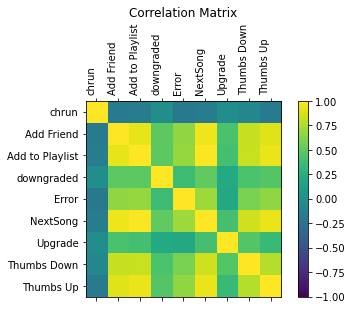

In [54]:
def plot_corr_matrix(correlations,attr):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    fig.autofmt_xdate(rotation = 90)
    plt.show()

plot_corr_matrix(corrmatrix, columns)

### Logistic Regression

#### Train, Validation, Test Split

In [88]:
train, rest = df.randomSplit([0.7, 0.3], seed = 42)
validation, test = rest.randomSplit([0.5, 0.5], seed = 42)

#### Build Pipeline

In [89]:
columns = ['Add Friend','Add to Playlist','downgraded',\
            'Error', 'NextSong', 'Upgrade', 'Thumbs Down', \
            'Thumbs Up']
label = StringIndexer(inputCol='chrun', outputCol='label')
feature_assembler = VectorAssembler(inputCols=columns, outputCol='model_features')
scaler = Normalizer(inputCol='model_features', outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages = [label, feature_assembler, scaler, lr])

#### Tune Model

In [90]:
def crossvalidation(pipeline):
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam,[0.0, 0.1]) \
        .build()


    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=10)
    cvModel = crossval.fit(train)
    return cvModel

In [91]:
cvModel = crossvalidation(pipeline)

#### Compute Accuracy of Best Model

In [92]:
cvModel.avgMetrics

[0.699471916971917, 0.699471916971917]

In [100]:
def model_evaluation(cvModel, validation):
    # get the prediction
    prediction = cvModel.transform(validation)
    # initialize the evaluator
    evaluator = BinaryClassificationEvaluator()
    # calculate AUC
    auc = evaluator.evaluate(
        prediction, {evaluator.metricName: 'areaUnderROC'})
    print('AUC: %0.3f' % auc)
    # compute TN, TP, FN, and FP
    prediction.groupBy('label', 'prediction').count().show()
    # Calculate the elements of the confusion matrix
    TN = prediction.filter('prediction = 0 AND label = prediction').count()
    TP = prediction.filter('prediction = 1 AND label = prediction').count()
    FN = prediction.filter('prediction = 0 AND label != prediction').count()
    FP = prediction.filter('prediction = 1 AND label != prediction').count()

    # since we have a small dataset, it is possible that we have some elements of the confusion matrix is 0
    def zero_division(n, d):
        return n / d if d else 'No value'

    # calculate accuracy, precision, recall, and F1-score
    accuracy = zero_division((TN + TP), (TN + TP + FN + FP))
    precision = zero_division(TP, (TP + FP))
    recall = zero_division(TP, (TP + FN))
    print('precision: ', precision)
    print('recall: ', recall)
    print('accuracy: ', accuracy)

    try:
        F = zero_division(2 * (precision*recall), (precision + recall))
        print('F1 score: ', F)
    except:
        print('no valid F1 score')
    return

In [94]:
model_evaluation(cvModel, validation)

AUC: 0.786
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|    1|
|  0.0|       0.0|   14|
+-----+----------+-----+

precision:  No value
recall:  0.0
accuracy:  0.9333333333333333
no valid F1 score


#### Build pipeline 2 with standard scaler

In [95]:
columns = ['Add Friend','Add to Playlist','downgraded',\
            'Error', 'NextSong', 'Upgrade', 'Thumbs Down', \
            'Thumbs Up']
label = StringIndexer(inputCol='chrun', outputCol='label')
feature_assembler = VectorAssembler(inputCols=columns, outputCol="model_features")
scaler = StandardScaler(inputCol='model_features', outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline2 = Pipeline(stages = [label, feature_assembler, scaler, lr])

In [96]:
cvModel2 = crossvalidation(pipeline2)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f92a90d3790>
Traceback (most recent call last):
  File "/Users/fengsiqi/Applications/spark-3.0.1-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'Normalizer' object has no attribute '_java_obj'


In [97]:
model_evaluation(cvModel2, validation)

AUC: 0.929
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|    1|
|  0.0|       0.0|   14|
+-----+----------+-----+

precision:  No value
recall:  0.0
accuracy:  0.9333333333333333
no valid F1 score


In [98]:
best_lr = cvModel2.bestModel
best_lr.stages[-1].coefficients

DenseVector([-0.1709, -0.0643, 0.1211, -0.256, -0.0613, 0.0376, 0.1924, -0.1094])

#### We trained our model on trainning set and choose the best model based on our validation set. Now we are going to use the best model we found to predict test set.

In [101]:
model_evaluation(cvModel2, test)

AUC: 0.709
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|   13|
|  0.0|       0.0|   38|
+-----+----------+-----+

precision:  No value
recall:  0.0
accuracy:  0.7450980392156863
no valid F1 score


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.